Copyright 2020 The "What Can I do Here? A Theory of Affordances In Reinforcement Learning" Authors. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Click to Install and import libraries.
# Please follow the instructions in the README for dependencies installation.
!git clone https://github.com/kkhetarpal/emdp.git
%cd emdp/
!pip install -e .
!pip install matplotlib==3.0.2

#@title General Imports
%tensorflow_version 2.x
from collections import defaultdict
import enum
import functools
import os
import random
import sys
import time
from datetime import datetime

import emdp
from emdp import actions
from emdp.gridworld import GridWorldPlotter
from emdp.gridworld import build_simple_grid
from emdp.gridworld.builder_tools import TransitionMatrixBuilder
from emdp.gridworld.env import GridWorldMDP
from emdp.gridworld.helper_utilities import get_state_after_executing_action
from emdp.gridworld.helper_utilities import check_can_take_action
from emdp.gridworld.helper_utilities import get_possible_actions
from emdp.gridworld.helper_utilities import get_state_after_executing_action
from emdp.gridworld.txt_utilities import get_char_matrix
from emdp.gridworld.txt_utilities import build_gridworld_from_char_matrix
from emdp.examples.simple import build_four_rooms_example
from emdp.utils import convert_int_rep_to_onehot, convert_onehot_to_int

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from numpy.linalg import inv

import seaborn as sns
import tensorflow as tf

color_ls = [[102, 120, 173],
            [118, 167, 125], 
            [198, 113, 113], 
            [230, 169, 132],
            [169, 193, 213],
            [192, 197, 182],
            [210, 180, 226]]
colors = [[shade / 255.0 for shade in rgb] for rgb in color_ls]
markers = ['o', 's', 'D', '^', '*', 'x', 'p', '+', 'v','|']

DEFAULT_ARROW_COLOR = '#a65628'

fatal: destination path 'emdp' already exists and is not an empty directory.
/content/emdp
Obtaining file:///content/emdp
  Found existing installation: emdp 0.0.4
    Can't uninstall 'emdp'. No files were found to uninstall.
  Running setup.py develop for emdp


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper functions

In [ ]:
#@title Plotting and verifying matrices.
def plot_environment(
    mdp, ax, wall_locs=None, plot_grid=False,
    grid_kwargs=None,
    wall_color=(0, 0, 0, 1), # R, G, B, alpha
    ):
  """Function to plot emdp environment

    Args:
      mdp: The MDP to use.
      ax: The axes to plot this on.
      wall_locs: Locations of the walls for plotting them in a different color.
      plot_grid: Boolean indicating if the overlay grid should be plotted.
      grid_kwargs: Grid keyword argrument specification.
      wall_color: RGB color of the walls.

    Returns:
      ax: The axes of the final plot.
      imshow_ax: The final plot.
  """
  grid_kwargs = grid_kwargs or {}

  # Plot states with white background.
  state_background = np.ones((mdp.size, mdp.size))

  # Walls appear in a different color.
  wall_img = np.ones((mdp.size, mdp.size, 4))
  if wall_locs is not None:
    for state in wall_locs:
      y_coord = state[0]
      x_coord = state[1]
      wall_img[y_coord, x_coord, :] = np.array(wall_color)

  # Render the heatmap and overlay the walls.
  imshow_ax = ax.imshow(state_background, interpolation=None)
  imshow_ax = ax.imshow(wall_img, interpolation=None)
  ax.grid(False)
  
  # Switch on flag if you want to plot grid 
  if plot_grid:
    for i in range(mdp.size + 1):
      ax.plot(
          np.arange(mdp.size + 1) - 0.5,
          np.ones(mdp.size + 1) * i - 0.5,
          **grid_kwargs)

    for i in range(mdp.size + 1):
      ax.plot(
          np.ones(mdp.size + 1) * i - 0.5,
          np.arange(mdp.size + 1) - 0.5,
          **grid_kwargs)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

  return ax, imshow_ax


def get_current_state_integer(state_):
  return np.argmax(state_, axis=0)


def get_stateid(x, y, size):
  """Converts an (x, y) coordinate into the state id."""
  return size * x + y


def _is_absorbing(state_int, mdp_size):
  """Checks if the state_int is an absorbing state"""
  return state_int == mdp_size * mdp_size


def _checking_P(P):
  """Checks if the P matrix is valid."""
  assert np.all(P <= 1.0) and np.all(P >= 0.0)
  assert not np.allclose(P, 1.0)
  assert not np.allclose(P, 0.0)


## Grid World Environment

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb1ec8b8be0>,
 <matplotlib.image.AxesImage at 0x7fb1e52d89e8>)

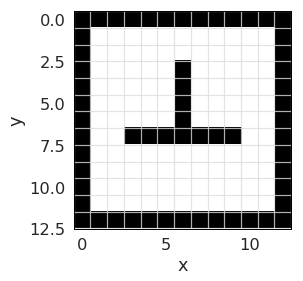

In [48]:
#@title Create the one room example.
_ONE_ROOM_TXT = """#############
#           #
#         g #
#     #     #
#     #     #
#     #     #
#     #     #
#  #######  #
#           #
#           #
#           #
#s          #
#############""".split('\n')


def build_one_room_example(gamma=0.99, seed=2017, p_success=1.0):
  char_matrix = get_char_matrix(_ONE_ROOM_TXT)
  return build_gridworld_from_char_matrix(
      char_matrix, p_success=p_success, seed=seed, gamma=gamma)


mdp, mdp_wall_locs = build_one_room_example()

gwp = GridWorldPlotter.from_mdp(mdp)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)

plot_environment(mdp, ax, wall_locs=mdp_wall_locs, plot_grid=True, 
                 grid_kwargs={'color':(220 / 255, 220 / 255, 220 / 255, 0.8)})


In [ ]:
# @title Functions for building transition matrices and affordance grids.

def build_simple_grid_stochastic_states(
    size=5, terminal_states=[], p_success=1):
  """
    Builds a simple grid where an agent can move LEFT, RIGHT, UP or DOWN
    and actions success with probability p_success.
    A terminal state is added if len(terminal_states) > 0 and will return matrix
    of size (|S|+1)x|A|x(|S|+1). Moving into walls does nothing.

    Note that this is a function modified from emdp package to customise mdp
    transitions.

    Args:
      size: size of the grid world
      terminal_state: the location of terminal states: a list of (x, y) tuples
      p_success: the probabilty that an action will be successful.

    Returns:
      P: transition matrix of size (|S|+1)x|A|x(|S|+1).
    """
  n_actions = 4
  p_fail = 1 - p_success

  n_states = size * size
  # The number of entries in the state vector corresponding to grid itself.
  grid_states = n_states
  # Add an entry to state vector for terminal state.
  if len(terminal_states) > 0:
    n_states += 1
  terminal_states = list(
      map(lambda tupl: int(size * tupl[0] + tupl[1]), terminal_states))

  # this helper function creates the state transition list for
  # taking an action in a state
  def create_state_list_for_action(state_idx, action, p_success):
    p_success = p_success
    p_fail = 1 - p_success
    transition_probs = np.zeros(n_states)
    if state_idx in terminal_states:
      # no matter what action you take you should go to the absorbing state
      transition_probs[-1] = 1
    elif state_idx == n_states - 1 and len(terminal_states) > 0:
      # absorbing state, you should just transition back here whatever action you take.
      transition_probs[-1] = 1

    elif action in [actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN]:
      # valid action, now see if we can actually execute this action
      # in this state:
      # TODO: distinguish between capability of slipping and taking wrong action vs failing to execute action.
      if check_can_take_action(action, state_idx, size):
        # yes we can
        possible_actions = get_possible_actions(state_idx, size)
        if action in possible_actions:
          transition_probs[get_state_after_executing_action(
              action, state_idx, size)] = p_success
          possible_actions.remove(action)
        for other_action in possible_actions:
          transition_probs[get_state_after_executing_action(
              other_action, state_idx, size)] = p_fail / len(possible_actions)

      else:
        possible_actions = get_possible_actions(state_idx, size)
        transition_probs[
            state_idx] = p_success  # cant take action, stay in same place
        for other_action in possible_actions:
          transition_probs[get_state_after_executing_action(
              other_action, state_idx, size)] = p_fail / len(possible_actions)

    else:
      raise InvalidActionError(
          'Invalid action {} in the 2D gridworld'.format(action))
    return transition_probs

  P = np.zeros((n_states, n_actions, n_states))
  for s in range(n_states):
    for a in range(n_actions):
      # MDP states are considered stochastic such that the probability
      # of success of a s,a pair is different for diff states,
      # in particular between the range of  [0.1, 1.0]
      p_success = random.uniform(0.10, 1.0)
      P[s, a, :] = create_state_list_for_action(s, a, p_success)

  return P

def _unit_test_P(P):
  assert np.allclose(P.sum(axis=2), 1), 'P matrix is not stochastic!'


def build_affordance_grid(
    affordances, size=13, p_success=1.0, terminal_states=()):
  """Builds a backbone for intent induced mdp transition matrix

  Args:
    affordances: AF of shape |S| * |A|
    size: The grid size of the mdp.
    p_success: The probability of success for a transition.
    mdp: Environment specified as mdp.
    terminal_states: List of terminal states.

  Returns:
    Returns model dynamics array of shape |S| x |A| x |S|
  """
  p_fail = 1 - p_success

  n_states = size * size
  grid_states = n_states  # the number of entries of the state vector
  # corresponding to the grid itself.
  if len(terminal_states) > 0:
    n_states += 1  # add an entry to state vector for terminal state
  terminal_states = list(
      map(lambda tupl: int(size * tupl[0] + tupl[1]), terminal_states))

  def create_state_list_for_action(state_idx, action):
    transition_probs = np.zeros(n_states)
    if state_idx in terminal_states:
      # no matter what action you take you should go to the absorbing state
      transition_probs[-1] = 1
    elif state_idx == n_states - 1 and len(terminal_states) > 0:
      # absorbing state, you should just transition back here whatever action you take.
      transition_probs[-1] = 1

    elif action in [actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN]:
      # valid action, now see if we can actually execute this action
      # in this state:
      if check_can_take_action(action, state_idx, size):
        # yes we can
        possible_actions = get_possible_actions(state_idx, size)
        if action in possible_actions:
          transition_probs[get_state_after_executing_action(
              action, state_idx, size)] = p_success
          possible_actions.remove(action)
        for other_action in possible_actions:
          transition_probs[get_state_after_executing_action(
              other_action, state_idx, size)] = p_fail / len(possible_actions)

      else:
        possible_actions = get_possible_actions(state_idx, size)
        transition_probs[
            state_idx] = p_success  # cant take action, stay in same place
        for other_action in possible_actions:
          transition_probs[get_state_after_executing_action(
              other_action, state_idx, size)] = p_fail / len(possible_actions)
    else:
      raise InvalidActionError(
          'Invalid action {} in the 2D gridworld'.format(action))
    return transition_probs

  n_states = size * size
  n_actions = 4
  if len(terminal_states) > 0:
    n_states += 1  # add an entry to state vector for terminal state

  P = np.zeros((n_states, n_actions, n_states))
  for s in range(n_states):
    for a in range(n_actions):
      if affordances[s, a] != 0.:
        P[s, a, :] = create_state_list_for_action(s, a)
      else:
        P[s, a, s] = 1.0
  return P


def _construct_dynamics(mdp, affordances, size, p_success=1.0, wall_locs=None):
  """
    Function to construct transition dynamics P
    Args:
      mdp: The mdp.
      affordances: The wall locations of the mdp.
      size: The grid size of the mdp.
      p_success: Probability of success.
      wall_locs: The location of the walls in the mdp.

    Returns:
      P: initialized transition matrix of shape |S| x |A| x |S|
    """

  if wall_locs is None:
    raise ValueError('Please give me wall locations.')

  grid_size = mdp.size

  assert len(mdp.terminal_states) == 1, 'Only one terminal state supported.'
  goal_loc = mdp.unflatten_state(
      convert_int_rep_to_onehot(mdp.terminal_states[0], mdp.state_space))
  # Attempt to make the desired gridworld.
  reward_spec = {(goal_loc[0], goal_loc[1]): +1}

  tmb = TransitionMatrixBuilder(grid_size, has_terminal_state=True)

  # For the purposes of constructing the dynamics matrix
  # and to match the way the library deals with MDPs, we set the
  # walls to have affordable actions.
  # affordances = affordances.copy()
  # affordances[wall_locs, :] = 1
  terminal_states = reward_spec.keys()
  basic_affordance_grid = build_affordance_grid(
      affordances,
      size=mdp.size,
      p_success=p_success,
      terminal_states=terminal_states)

  tmb._P = basic_affordance_grid
  for (r, c) in wall_locs:
    tmb.add_wall_at((r, c))
  P = tmb.P
  _unit_test_P(P)
  _checking_P(P)
  return P


## Affordances

In [ ]:
#@title Function to compute intent completion.
def _get_intent_completed(
    mdp, state, action, statet,
    threshold=0.0,
    intent_name='collection',
    P_AF=None):
  """Determines if a transition completed an intent.

  Args:
    mdp: The MDP to evaluate the intent on.
    state: The one hot representation of the current state
    action: The integer representation of the action (currently unused).
    statet: The state after taking the action.
    threshold: The threshold to select actions with
    intent_name: The name of the intent to calculate. Three intents are
      currently supported "collection", "up" and "left". Collection is the union
      over all intents.
    P_AF: A probability transition matrix for the affordances.

  Returns:
    An integer that represents if the intent is completed.
  """
  x_t, y_t = mdp.unflatten_state(state)
  x_tp1, y_tp1 = mdp.unflatten_state(statet)

  delta_x = x_t - x_tp1
  delta_y = y_t - y_tp1

  state_int = convert_onehot_to_int(state)
  next_state_int = convert_onehot_to_int(statet)

  # Select affordable actions based on the threshold.
  # Default value is True for default threshold=0.0
  prob_gt_threshold = True
  if P_AF is not None:
    prob_of_going_there = P_AF[state_int, action, next_state_int]
  else:
    prob_of_going_there = mdp.P[state_int, action, next_state_int]
  prob_gt_threshold = prob_of_going_there >= threshold

  if intent_name == 'collection':
    # If the agent has moved in any direction return a 1.0.
    if (int(delta_x) or int(delta_y)) and prob_gt_threshold:
      return 1.0
    else:
      return 0.0
  elif intent_name == 'up':
    if not(_is_absorbing(next_state_int, mdp.size)):
      if (x_tp1 < x_t) and prob_gt_threshold:
        return 1.0
      else:
        return 0.0
    else:
      if action==actions.UP:
        return 1.0
      else:
        return 0.0
  elif intent_name == 'left':
    if not(_is_absorbing(next_state_int, mdp.size)):
      if (y_tp1 < y_t)  and prob_gt_threshold:
        return 1.0
      else:
        return 0.0
    else:
      if action==actions.LEFT:
        return 1.0
      else:
        return 0.0
  else:
    print("Not a valid Intent, See _get_intent_completed")

In [ ]:
#@title Function to compute the affordances from an intent completion function.
def _compute_affordances(
    mdp, n_states, n_actions, intent_name,
    threshold, mdp_wall_locs):
  '''
  Args:
    n_states: number of states in mdp
    n_actions: number of actions in mdp 
    intent_name: name of the intent collection, up, etc.
    threshold: float value between 0-1
    mdp_wall_locs: list of mdp wall locations

  Returns:
    Affordances in the form of a |S| * |A| array. The array has entries of
    1.0 or 0.0 based on  the intent I_a(s') is true or not respectively.
  '''
  affordances = np.zeros((n_states, n_actions))
  for s in range(n_states):
    x_t, y_t = mdp.unflatten_state(
        convert_int_rep_to_onehot(s, mdp.state_space))
    if (x_t, y_t) in mdp_wall_locs:
      # You're in a wall nothing is affordable.
      continue
    for a in range(n_actions):
      if not(_is_absorbing(s, mdp.size)):
        s_next = get_state_after_executing_action(a, s, mdp.size)
        x, y = mdp.unflatten_state(
            convert_int_rep_to_onehot(s_next, mdp.state_space))
        if (x,y) in mdp_wall_locs:
          s_next = s
        intent = _get_intent_completed(
            mdp, state=convert_int_rep_to_onehot(s, mdp.state_space),
            action=a, statet=convert_int_rep_to_onehot(
                s_next, mdp.state_space),
            threshold=threshold, intent_name=intent_name)
        affordances[s, a] = intent

    # Hard code terminal states to be affordable since all actions are possible.
    if s in mdp.terminal_states:
      affordances[s, :] = 1.0
  # Hard code absorbing state to be affordable (Environmental quirk).
  affordances[-1, :] = 1.0
  return affordances

## Value Iteration and Policy Evaluation algorithms

In [ ]:
#@title Code for value iteration.
# We build this function on the following base code:
# https://github.com/andrecianflone/policy_value_iteration
def value_iteration(
    r, p, theta=0.0001, gamma=0.99, max_iteration=100,
    AF=None, seed=None, min_mask_value=-10, mdp_wall_locs=None):
  """Value iteration computes value & policy for a reward and transiton matrix.

    Args:
      r: Rewards, array of shape |S| x |A|.
      p: State transition probabilities, array of shape |S| x |A| x |S|.
      theta: Stop if the change in value fn is less than this value.
      gamma: Discount factor.
      max_iteration: Maximum number of iterations to run VI.
      AF: Affordances of shape |S| x |A|.
      seed: Seed value for randomness.
      min_mask_value: An optional check for values to not be negative.
      mdp_wall_locs: Wall locations in the mdp.

    Returns:
      pi: Policy, |S| x |A|.
      v: State values, |S|.
      it: Number of iterations.
      seconds: Planning time in seconds.
      v_log: Log of value functions from init to convergence.
  """
  if AF is not None:
    AF = AF.copy()
    assert mdp_wall_locs is not None, 'If AF is given, wall locs must also be given.'
  if seed is not None:
    np.random.seed(seed)
    random.seed(seed)
  t1 = datetime.now()
  n_states, n_actions = p.shape[:2]
  v = np.zeros(n_states)
  v_log = np.zeros((max_iteration + 1, n_states))

  if mdp_wall_locs:
    wall_states_idx = list(
        map(convert_onehot_to_int, map(mdp.flatten_state, mdp_wall_locs)))

  # Mask out walls to be zero. But uncovered states should be -inf.
  if AF is not None:
    # Accounting for emdp environment behaviour.
    AF[wall_states_idx] = 1
    mask = np.logical_not(AF).astype(np.float32)
  for it in range(max_iteration+1):
    q = r + gamma * np.einsum('ijk, k->ij', p, v)
    minimum_v = np.min(q)

    if AF is not None:
      q = AF * q + mask * minimum_v
    
    v_new = np.max(q, axis=1)
    if np.all(np.absolute(v-v_new) < theta):
      v = v_new
      v_log[it, :] = v
      v_iters = v_log[:it, :]
      break
    v = v_new
    v_log[it, :] = v
    v_iters = v_log[:it, :]

  # Greedy policy extraction.
  q_values = r + gamma * np.einsum('ijk, k->ij', p, v_new)
  if AF is not None:
    q_values = q_values * AF + mask * minimum_v

  # Use "random" argmax with stochastic tie-breaking:
  rargmax = lambda arr: np.random.choice(np.flatnonzero(arr))
  best_actions = np.apply_along_axis(
      rargmax, 1, np.isclose(q_values, q_values.max(-1, keepdims=True)))
  pi = np.eye(r.shape[1])[best_actions]
  assert pi.shape == r.shape
 
  t2 = datetime.now()
  seconds = (t2 - t1).total_seconds()
  return pi, v, it+1, seconds, v_log

In [ ]:
#@title Code for policy evaluation.

def _policy_evaluation_exact(pi, r, p, gamma=0.99):
    """
    Evaluate policy by taking the inverse
    Args:
      pi: Policy, array of shape |S| x |A|.
      r: Rewards, array of shape |S| x |A|.
      p: State transition probabilities, array of shape |S| x |A| x |S|.
    Return:
      v: 1D array with updated state values
    """
    # Rewards according to policy: Hadamard product and row-wise sum
    r_pi = np.einsum('ij,ij->i', pi, r)

    # Policy-weighted transitions:
    # multiply p by pi by broadcasting pi, then sum second axis
    # result is an array of shape |S| x |S|
    p_pi = np.einsum('ijk, ij->ik', p, pi)
    v = np.dot(inv((np.eye(p_pi.shape[0]) - gamma*p_pi)), r_pi)
    return v

#Sec 6.1 Experiment 1: Planning with Intents
Evaluating the impact of intents and affordances on planning.  $||V^{\pi^{*}_{I}}_{M}  - V^{\pi^{*}}_{M}||_{n}$

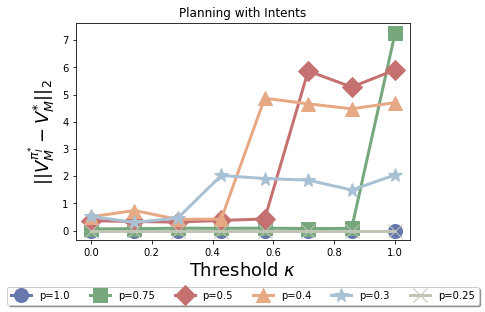

In [ ]:
#@title Evaluate policy obtained from MDP M vs I in original MDP M
#------------------------------------------------------------------------#
# 1. Compute optimal value function and optimal policy in I 
# 2. Policy Evaluation in MDP M
# 3. Report planning time in M vs I 
# 4. Report L2 value loss 
#------------------------------------------------------------------------#

p_success_probs = [1.0, 0.75, 0.50, 0.40, 0.30, 0.25]
thresholds = [0, 0.15, 0.25, 0.35, 0.45, 0.65, 0.75, 1.0]
max_iterations = 10000

# Initialize empty arrays to store results.
valuefn_I = np.zeros(
    (len(p_success_probs), len(thresholds), max_iterations+1, mdp.state_space))
v_pi_star_I_M_thresholds = np.zeros(
    (len(p_success_probs), len(thresholds), mdp.state_space))
V_star_I_plan_time = np.zeros((len(p_success_probs), len(thresholds)))
V_star_M_plan_time = np.zeros(len(p_success_probs))
v_pi_star_M_M = np.zeros((len(p_success_probs), mdp.state_space))

# Stores the ratio of |AF|/(|S| x |A|)
AF_SA_size_ratio = np.zeros((len(p_success_probs), len(thresholds)))

# Iterate over the thresholds and success probs to create data for the plot.
for idx_p, p_success in enumerate(p_success_probs):
  for ind, k in enumerate(thresholds):
    # Create an mdp with a success prob of p_success
    mdp, mdp_wall_locs = build_one_room_example(p_success=p_success)

    # |S| x |A| size in base MDP M.
    state_action_space = mdp.state_space * mdp.action_space

    # Compute affordance matrix.
    AF = _compute_affordances(
        mdp=mdp,
        n_states=mdp.state_space,
        n_actions=mdp.action_space,
        intent_name="collection",
        threshold=k,
        mdp_wall_locs=mdp_wall_locs)
    
    # |S| x |A| size in intended MDP M_I
    AF_size = np.count_nonzero(AF)
    AF_SA_size_ratio[idx_p, ind] = AF_size/state_action_space
    
    #construct P_I with a determinsitic probability
    P_affordances = _construct_dynamics(
        mdp, affordances=AF, size=mdp.size, p_success=1.0,
        wall_locs=mdp_wall_locs)

    _checking_P(P_affordances)

    try:
      # Compute optimal value function in MDP I with affordances
      (policy_star_I, V_star_I, _,
      V_star_I_seconds, V_star_I_iters) = value_iteration(
          mdp.R, P_affordances, max_iteration=max_iterations,
          AF=AF, mdp_wall_locs=mdp_wall_locs)
    except RuntimeError:
      print(f'No affordances found for threshold={k}, p_success={p_success}.')
      continue
    
    V_star_I_plan_time[idx_p, ind] = V_star_I_seconds
    
    # Evaluate the optimal policies from MDP I in the original mdp M.
    v_pi_star_I_M_thresholds[idx_p, ind, :] = _policy_evaluation_exact(
        pi=policy_star_I, 
        r=mdp.R, p=mdp.P, 
        gamma=mdp.gamma)
  
  # Compute optimal value function in original mdp.P
  V_star_M = np.zeros(mdp.state_space)
  (policy_star_M, V_star_M, _,
   V_star_M_seconds, V_star_M_iters) = value_iteration(
       mdp.R, mdp.P, max_iteration=max_iterations)

  V_star_M_plan_time[idx_p] = V_star_M_seconds

  # Evaluate the optimal policies in M in the original environment M 
  v_pi_star_M_M[idx_p] = _policy_evaluation_exact(
      pi=policy_star_M, 
      r=mdp.R, 
      p=mdp.P, 
      gamma=mdp.gamma)

# Compute the absolute error wrto the ground mdp.
value_loss_to_plot = np.zeros((len(p_success_probs), len(thresholds)))
for p_id in range(len(p_success_probs)):
  for _thresh in range(len(thresholds)):
      value_loss_to_plot[p_id, _thresh] = np.linalg.norm(
          abs(v_pi_star_M_M[p_id, :] - 
              v_pi_star_I_M_thresholds[p_id, _thresh, :])
          )

fig, ax = plt.subplots()
x_axis = np.linspace(0, 1, len(thresholds))
for i in range(value_loss_to_plot.shape[0]):
  ax.plot(
      x_axis, value_loss_to_plot[i, :], color=colors[i],
      label='p={}'.format(p_success_probs[i]), linewidth=3.00,
      marker=markers[i], markersize=14)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19),
          fancybox=True, shadow=True, ncol=7,
          facecolor='w', fontsize=10)
ax.set_xlabel("Threshold $\kappa$", fontsize=18)
ax.set_ylabel("$ ||V^{\pi^{*}_{I}}_M - V^{*}_M||_2$", fontsize=18) 
plt.title("Planning with Intents")
matplotlib.rc('axes', edgecolor='black')
plt.show()

# Sec 6.2 Experiment 2: Planning time with & w/o Affordances

In [ ]:
#@title Utility to create One-room and Pachinko Environments

# One-Room gridsize_dict
ONE_ROOM_DIFF_GRIDSIZES = {
    7: """#######
#     #
#   g #
#  #  #
# ### #
#s    #
#######""".split('\n'),
    9: """#########
#       #
#     g #
#       #
#       #
#       #
#       #
#s      #
#########""".split('\n'),
    13: """#############
#           #
#         g #
#     #     #
#     #     #
#     #     #
#     #     #
#  #######  #
#           #
#           #
#           #
#s          #
#############""".split('\n'),
    15: """###############
#             #
#           g #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#s            #
###############""".split('\n'),
    17: """#################
#               #
#             g #
#       #       #
#       #       #
#       #       #
#       #       #
#       #       #
#       #       #
#  ###########  #
#               #
#               #
#               #
#               #
#               #
#s              #
#################""".split('\n'),
    19: """###################
#                 #
#               g #
#        #        #
#        #        #
#        #        #
#        #        #
#        #        #
#        #        #
#        #        #
#  #############  #
#                 #
#                 #
#                 #
#                 #
#                 #
#                 #
#s                #
###################""".split('\n'),
    25: """#########################
#                       #
#                     g #
#                       #
#                       #
#                       #
#           #           #
#           #           #
#           #           #
#           #           #
#           #           #
#           #           #
#           #           #
#   #################   #
#                       #
#                       #
#                       #
#                       #
#                       #
#                       #
#                       #
#                       #
#                       #
#s                      #
#########################""".split('\n')
}

def build_one_room_gridsize(gamma=0.99, seed=2017,p_success=1.0, grid_size=13):
  _ONE_ROOM_TXT = ONE_ROOM_DIFF_GRIDSIZES[grid_size]
  char_matrix = get_char_matrix(_ONE_ROOM_TXT)
  return build_gridworld_from_char_matrix(
      char_matrix, p_success=p_success, seed=seed, gamma=gamma)


# pachinko_gridsize_dict
PACHINKO_DIFF_GRIDSIZES = {
    7: """#######
#     #
# # # #
#  g  #
# # # #
# s   #
#######""".split('\n'),
    9: """#########
#       #
# # # # #
#    g  #
# # # # #
#       #
# # # # #
# s     #
#########""".split('\n'),
    13: """#############
#           #
# # # # # # #
#        g  #
# # # # # # #
#           #
# # # # # # #
#           #
# # # # # # #
#           #
# # # # # # #
# s         #
#############""".split('\n'),
    15: """###############
#             #
# # # # # # # #
#          g  #
# # # # # # # #
#             #
# # # # # # # #
#             #
# # # # # # # #
#             #
# # # # # # # #
#             #
# # # # # # # #
# s           #
###############""".split('\n'),
    17: """#################
#               #
# # # # # # # # #
#            g  #
# # # # # # # # #
#               #
# # # # # # # # #
#               #
# # # # # # # # #
#               #
# # # # # # # # #
#               #
# # # # # # # # #
#               #
# # # # # # # # #
# s             #
#################""".split('\n'),
    19: """###################
#                 #
# # # # # # # # # #
#              g  #
# # # # # # # # # #
#                 #
# # # # # # # # # #
#                 #
# # # # # # # # # #
#                 #
# # # # # # # # # #
#                 #
# # # # # # # # # #
#                 #
# # # # # # # # # #
#                 #
# # # # # # # # # #
# s               #
###################""".split('\n'),
    25: """#########################
#                       #
# # # # # # # # # # # # #
#                    g  #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
#                       #
# # # # # # # # # # # # #
# s                     #
#########################""".split('\n')
}

def build_pachinko_gridsize(gamma=0.99, seed=2017,p_success=1.0, grid_size=13):
  _PACHINKO_ROOMS_TXT = PACHINKO_DIFF_GRIDSIZES[grid_size]
  char_matrix = get_char_matrix(_PACHINKO_ROOMS_TXT)
  return build_gridworld_from_char_matrix(
      char_matrix, p_success=p_success, seed=seed, gamma=gamma)



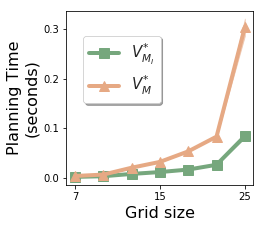

In [ ]:
#@title Planning Time with Increasing Grid Size: One-Room
#------------------------------------------------------------------------#
# 1. MDP's will have p_success 0.5
# 2. Choose a threshold of 0.5 for AF computation
# 3. For different factors in range(factors):
#    Compute V_star_M, V_star_M_I
#    Planning time for each
#    Return V_star_M, V_star_M_I plan times
# 4. Multiple runs to account for randomness
#------------------------------------------------------------------------#

seed = 10000 
p_success = 0.5
threshold = 0.5
max_iterations = 10000
nruns = 10
grid_sizes = [7, 9, 13, 15, 17, 19, 25] 

V_star_I_plan_time = np.zeros((len(grid_sizes), nruns))
V_star_M_plan_time = np.zeros((len(grid_sizes), nruns))

# Run VI for MDP M
for size_idx, size_val in enumerate(grid_sizes):
  for run_id in range(nruns):
    # Create an mdp with grid size size_val, fixed p
    _mdp, _mdp_walls = build_one_room_gridsize(
        grid_size=size_val, p_success=p_success)

    # Compute V* in original _mdp.P
    (policy_star_M, V_star_M, _,
    V_star_M_seconds, V_star_M_iters) = value_iteration(
        _mdp.R, _mdp.P, max_iteration=max_iterations, 
        seed=seed+run_id)
  
    V_star_M_plan_time[size_idx, run_id] = V_star_M_seconds

    # Compute Affordances AF based on intent I
    _AF = _compute_affordances(mdp=_mdp,
                              n_states=_mdp.state_space,
                              n_actions=_mdp.action_space,
                              intent_name="collection",
                              threshold=threshold,
                              mdp_wall_locs=_mdp_walls)

    #construct P_I with a determinsitic probability
    _P_affordances = _construct_dynamics(_mdp,
                                        affordances=_AF,
                                        size=_mdp.size,
                                        p_success=1.0,
                                         wall_locs=_mdp_walls)
    _checking_P(_P_affordances)

    # Compute V*_I in mdp M_I with AF
    (policy_star_I, V_star_I, _,
    V_star_I_seconds, V_star_I_iters) = value_iteration(
        _mdp.R,  _P_affordances, max_iteration=max_iterations,
        seed=seed+run_id)
    
    V_star_I_plan_time[size_idx, run_id] = V_star_I_seconds

V_star_I_plan_time_avg = np.mean(V_star_I_plan_time, axis=1)
V_star_I_plan_time_std = np.std(V_star_I_plan_time, axis=1)
V_star_I_plan_time_CI = V_star_I_plan_time_std/np.sqrt(nruns)


V_star_M_plan_time_avg = np.mean(V_star_M_plan_time, axis=1)
V_star_M_plan_time_std = np.std(V_star_M_plan_time, axis=1)
V_star_M_plan_time_CI = V_star_M_plan_time_std/np.sqrt(nruns) 

#@title Plot Planning Time: TwoRooms
fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(1,1,1)
# sns.set_context("paper")
sns.set_style('white')
sns.set_context("paper", font_scale=1.85)

fig.patch.set_facecolor('1.0')

plt.grid(False)
x_axis = grid_sizes
xi = list(range(len(x_axis)))

ax1.plot(xi, V_star_I_plan_time_avg, color = colors[1],  label = '$V^{*}_{M_I}$', 
         linewidth=4.00, marker=markers[1], markersize=10)
ax1.fill_between(xi, V_star_I_plan_time_avg-V_star_I_plan_time_CI,
                   V_star_I_plan_time_avg+V_star_I_plan_time_CI,
                   facecolor=colors[1], edgecolor=colors[1], alpha=0.5)

ax1.plot(xi, V_star_M_plan_time_avg, color = colors[3],  label = '$V^{*}_{M}$',
         linewidth=4.00, marker=markers[3], markersize=10)
ax1.fill_between(xi, V_star_M_plan_time_avg-V_star_M_plan_time_CI,
                   V_star_M_plan_time_avg+V_star_M_plan_time_CI,
                   facecolor=colors[3], edgecolor=colors[3], alpha=0.5)

ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.9),
          fancybox=True, shadow=True, ncol=1,
          facecolor='w', fontsize=15)
ax1.set_xlabel("Grid size", fontsize=16)
ax1.set_ylabel("Planning Time\n(seconds)", fontsize=16) 
xticks_pos = [0, 3, 6]
ax1.set_xticks(xticks_pos)
ax1.set_xticklabels([grid_sizes[i] for i in xticks_pos])
fig.tight_layout()

plt.show()


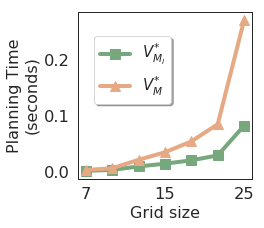

In [ ]:
#@title Planning Time with Increasing Grid Size: Pachinko
#------------------------------------------------------------------------#
# 1. MDP's will have p_success 0.5
# 2. Choose a threshold of 0.5 for AF computation
# 3. For different factors in range(factors):
#    Compute V_star_M, V_star_M_I
#    Planning time for each
#    Return V_star_M, V_star_M_I plan times
#------------------------------------------------------------------------#

seed = 10000
p_success = 0.5
threshold = 0.5
max_iterations = 20000
grid_sizes = [7, 9, 13, 15, 17, 19, 25] 
nruns = 10

outer_dir = os.path.dirname('/content/')
dir_name = "planning_valueloss"
dir_name = os.path.join(outer_dir, dir_name)
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

V_star_I_plan_time = np.zeros((len(grid_sizes), nruns))
V_star_M_plan_time = np.zeros((len(grid_sizes), nruns))


# Run VI for MDP M
for size_idx, size_val in enumerate(grid_sizes):
  for run_id in range(nruns):
    # Create an mdp with grid size size_val, fixed p
    _mdp, _mdp_walls = build_pachinko_gridsize(
        grid_size=size_val, p_success=p_success)

    # Compute V* in original _mdp.P
    (policy_star_M, V_star_M, _,
    V_star_M_seconds, V_star_M_iters) = value_iteration(
        _mdp.R, _mdp.P, max_iteration=max_iterations,
        seed=seed+run_id)
  
    V_star_M_plan_time[size_idx, run_id] = V_star_M_seconds

    # Compute Affordances AF based on intent I
    _AF = _compute_affordances(mdp=_mdp,
                              n_states=_mdp.state_space,
                              n_actions=_mdp.action_space,
                              intent_name="collection",
                              threshold=threshold,
                              mdp_wall_locs=_mdp_walls)
    
    
    #construct P_I with a determinsitic probability
    _P_affordances = _construct_dynamics(_mdp,
                                        affordances=_AF,
                                        size=_mdp.size,
                                        p_success=1.0,
                                        wall_locs=_mdp_walls)
    _checking_P(_P_affordances)

    # Compute V*_I in mdp M_I with AF
    (policy_star_I, V_star_I, _,
    V_star_I_seconds, V_star_I_iters) = value_iteration(
        _mdp.R,  _P_affordances, max_iteration=max_iterations,
        seed=seed+run_id)
    
    V_star_I_plan_time[size_idx, run_id] = V_star_I_seconds


V_star_I_plan_time_avg = np.mean(V_star_I_plan_time, axis=1)
V_star_I_plan_time_std = np.std(V_star_I_plan_time, axis=1)
V_star_I_plan_time_CI = V_star_I_plan_time_std/np.sqrt(nruns)


V_star_M_plan_time_avg = np.mean(V_star_M_plan_time, axis=1)
V_star_M_plan_time_std = np.std(V_star_M_plan_time, axis=1)
V_star_M_plan_time_CI = V_star_M_plan_time_std/np.sqrt(nruns)  


#@title Plot Planning Time: Pachinko
fig = plt.figure(figsize=(4,3.5))
ax1 = fig.add_subplot(1,1,1)
sns.set_style('white')
sns.set_context("paper", font_scale=1.85)
fig.patch.set_facecolor('1.0')
plt.grid(False)
x_axis = grid_sizes
xi = list(range(len(x_axis)))

ax1.plot(xi, V_star_I_plan_time_avg, color = colors[1],  label = '$V^{*}_{M_I}$', 
         linewidth=4.00, marker=markers[1], markersize=10)
ax1.fill_between(xi, V_star_I_plan_time_avg-V_star_I_plan_time_CI,
                   V_star_I_plan_time_avg+V_star_I_plan_time_CI,
                   facecolor=colors[1], edgecolor=colors[1], alpha=0.5)

ax1.plot(xi, V_star_M_plan_time_avg, color = colors[3],  label = '$V^{*}_{M}$',
         linewidth=4.00, marker=markers[3], markersize=10)
ax1.fill_between(xi, V_star_M_plan_time_avg-V_star_M_plan_time_CI,
                   V_star_M_plan_time_avg+V_star_M_plan_time_CI,
                   facecolor=colors[3], edgecolor=colors[3], alpha=0.5)

ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.9),
          fancybox=True, shadow=True, ncol=1,
          facecolor='w', fontsize=15)
ax1.set_xlabel("Grid size", fontsize=16)
ax1.set_ylabel("Planning Time\n(seconds)", fontsize=16) 
xticks_pos = [0, 3, 6]
ax1.set_xticks(xticks_pos)
ax1.set_xticklabels([grid_sizes[i] for i in xticks_pos])
fig.tight_layout()

plt.show()

# Sec 6.3 Experiment 3: Planning Loss Bound
$\Big|\Big|V^*_M - V^{\pi^{*}_{\hat{M}_{{{\mathcal{A} \mathcal{F}}_{\cal I}}}}}_M \Big|\Big|_{\infty}$

## Model Learning

To learn the model from the experience-data, we consider the count based approach:

Transition Dynamics computation $\hat{P_{\cal I}}(s' \mid s,a) = \frac{1}{n} \sum \text{COUNT}(s,a, s')$


In [35]:
#@title Helper functions to collect data and create transition matrices.
class Actions(enum.IntEnum):
  LEFT = actions.LEFT
  RIGHT = actions.RIGHT
  UP = actions.UP
  DOWN = actions.DOWN
  
def get_randomized_state(mdp):
  """Generates a random state and sets mdp current state to that."""
  state_id = np.random.randint(0, mdp.state_space-1)
  x, y = mdp.unflatten_state(convert_int_rep_to_onehot(state_id, mdp.state_space))
  while (x,y) in mdp_wall_locs:
    state_id = np.random.randint(0, mdp.state_space-1)
    x, y = mdp.unflatten_state(
        convert_int_rep_to_onehot(state_id, mdp.state_space))
  mdp.set_current_state_to((x,y))
  state_onehot = mdp.current_state
  return state_onehot

def get_trajectories_transitions(
    mdp, num_trajectories=500, max_trajectory_length=50, policy=None,
    intent_name='collection', random_starts=False, seed=None):
  """Takes transitions samples from an environment.

  Args:
    mdp: The MDP to evaluate the intent on.
    num_trajectories: The total number of trajectories to sample.
    max_trajectory_length: The maximum length of the trajectory.
    policy: The policy to sample using. If none is given a random policy
      is used. The policy must take a single argument, the one hot
      representation of the state. 
    intent_name: Name of the intent to be considered
    random_starts: Data collection including random starts
    seed: seed for randomness 
  Returns:
    The trajectories collected from the environment:
      This is a 4-tuple containing the batch of state, action, state' 
      and reward
    Human Readable transitions:
      A set containing the unique transitions in the trajectory batch.
  """
  if seed is not None:
    np.random.seed(seed)
    random.seed(seed)
    print(f'seed set to {seed}')

  trajectory = []
  if random_starts:
    s_t = get_randomized_state(mdp)
  else:
    s_t = mdp.reset()
  trajectory_length = 0
  human_readable = set()
  if policy is None:
    def policy(_):
      return np.random.randint(mdp.action_space)

  for _ in range(num_trajectories):
    action = policy(s_t)
    s_tp1, reward, done, _ = mdp.step(action)
    state_int = get_current_state_integer(s_t)
    intent = _get_intent_completed(
        mdp, s_t, action, s_tp1, intent_name=intent_name)

    # Human readable vesion:
    human_readable.add((
        mdp.unflatten_state(s_t),
        Actions(action),
        mdp.unflatten_state(s_tp1),
        reward))

    trajectory.append((
        convert_onehot_to_int(s_t), action,
        convert_onehot_to_int(s_tp1), reward)
    )
    trajectory_length += 1
    if done or trajectory_length > max_trajectory_length:
      if random_starts:
        s_t = get_randomized_state(mdp)
      else:
        s_t = mdp.reset()
    else:
      s_t = s_tp1

  return trajectory, human_readable

def get_stochastic_states_P(mdp, wall_locs):
  """
    Function to initialize P with non-uniform probability
    of transitioning to the neighborhood states.
    Introduces stochasticity in actions.

    Args:
      mdp: The mdp to get the affordances from.
      wall_locs: The wall locations of the mdp.

    Returns:
      P: initialized transition matrix
    """
  grid_size = mdp.size

  assert len(mdp.terminal_states) == 1, 'only one terminal state supported.'
  goal_loc = mdp.unflatten_state(
      convert_int_rep_to_onehot(
          mdp.terminal_states[0], mdp.state_space))

  # Attempt to make the desired gridworld.
  reward_spec = {(goal_loc[0], goal_loc[1]): +1}

  tmb = TransitionMatrixBuilder(grid_size, has_terminal_state=True)
  terminal_state = mdp.unflatten_state(
      convert_int_rep_to_onehot(mdp.terminal_states, mdp.state_space))
  stochastic_P = build_simple_grid_stochastic_states(
      size=grid_size,
      terminal_states=[terminal_state])
  tmb._P = stochastic_P
  for (r, c) in wall_locs:
    tmb.add_wall_at((r, c))
  P = tmb.P
  _unit_test_P(P)
  _checking_P(P)
  return P

def get_uniform_phat(mdp, wall_locs):
  """
  Function to initialize P with uniform probability
  of transitioning to the neighborhood states

  Args:
    mdp: The to get a uniform starting state for.
    wall_locs: The locations of the walls.

  Returns:
    P: initialized transition matrix
  """
  grid_size = mdp.size

  assert len(mdp.terminal_states) == 1, 'only one terminal state supported.'
  goal_loc = mdp.unflatten_state(
      convert_int_rep_to_onehot(
          mdp.terminal_states[0], mdp.state_space))
  # Attempt to make the desired gridworld.
  reward_spec = {(goal_loc[0], goal_loc[1]): +1}

  tmb = TransitionMatrixBuilder(grid_size,  has_terminal_state=True)
  terminal_state_idx = mdp.unflatten_state(
      convert_int_rep_to_onehot(mdp.terminal_states, mdp.state_space))
  uniform_P = build_simple_grid(
      size=grid_size, 
      terminal_states=[terminal_state_idx],
      p_success=0.25)
  tmb._P = uniform_P
  for (r, c) in wall_locs:
    tmb.add_wall_at((r, c))
  P = tmb.P
  _unit_test_P(P)
  _checking_P(P)
  return P



In [36]:
#@title Function: Code to learn a count based model from data.

def learn_model_from_data(
    mdp, mdp_wall_locs,
    num_trajectories=50, 
    max_trajectory_length=10,
    random_starts=False,
    affordances=None,
    policy=None,
    seed=None,
    trajectories=None):
  """Learns a transition dynamics from sampled data.

  Args:
    mdp: The MDP to sample from.
    mdp_wall_locs: The wall locations in that mdp.
    num_trajectories: The total number of trajectories to sample.
    max_trajectory_length: The maximum length of the trajectory.
    random_starts: rollouts are performed with random starting state.
    affordances: The affordances of shape |S| * |A|
    policy: The policy to sample using. If none is given a random policy
      is used. The policy must take a single argument, the one hot
      representation of the state. 
    seed: seed for randomness in any sampling used.
    passing_data: set True if previously collected data is being passed
    trajectories: tf trajectories from previously collected data
  Returns:
    The transition model P_hat
  """
  if seed is not None:
    np.random.seed(seed)
    random.seed(seed)

  Mhat = np.zeros((mdp.state_space, mdp.action_space, mdp.state_space))
  Phat = np.zeros((mdp.state_space, mdp.action_space, mdp.state_space))

  if trajectories is None:
    trajectories, _ = get_trajectories_transitions(
        mdp=mdp, num_trajectories=num_trajectories,
        max_trajectory_length=max_trajectory_length,
        random_starts=random_starts)
  else:
    trajectories = trajectories

  for (s,a,s_dash, r) in trajectories:
    Mhat[s,a,s_dash] += 1

  # Use get_random_phat instead of a naive initialization to take into account
  # the wall locations and the fact that we cannot transition into walls.
  Phat_init_uniform = get_uniform_phat(mdp, mdp_wall_locs)
  
  for (s, a, s_dash, r) in trajectories:
    if affordances is None or affordances[s,a] !=0:
      Phat[s,a,s_dash] = Mhat[s,a,s_dash]/np.sum(Mhat[s,a,:])

  # Copy over "initialized uniform state transition" here.
  # i.e. if you have never seen a transition (s, a), 
  # P (s,a, s') = 1/4 (except walls)
  P_visited_mask = np.sum(Phat, 2) == 0
  for s in range(mdp.state_space):
    for a in range(mdp.action_space):
      if P_visited_mask[s, a]:
        if affordances is None or affordances[s,a] >= 0.0:
          Phat[s, a] = Phat_init_uniform[s, a]

  return Phat

In [38]:
#@title Planning Value Loss Evaluation
#------------------------------------------------------------------------#
# 1. Computationally build affordances
# 2. Learn a model for those affordances from the data experience
# 3. Compute optimal value function and optimal policy in M_M and M_hat_I_M
# 4. Policy Evaluation in MDP M 
# 5. Compare loss for different number of samples 
# 6. Hypothesis: the planning value loss shrinks with more and more data
#    for low data regime, there would be an intermediate value of |AF_I| which
#    yields the optimal planning value loss.
#------------------------------------------------------------------------#

n_trajectories = [250, 400, 500, 750, 2000, 10000]
thresholds = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]

p_success = 0.70 #@param {type:"slider", min:0, max:1, step:0.1}
max_iterations = 10000 #@param {type:"integer"}
max_trajectory_length =  10#@param {type:"integer"}
seed = 10000 #@param {type:"integer"}
nruns = 10

v_pi_star_Mhat_I_M_thresh_nsamples = np.zeros(
    (nruns,  len(n_trajectories), len(thresholds), mdp.state_space))

# Create an mdp M
mdp, mdp_wall_locs = build_pachinko_gridsize(grid_size=19)

mdp.P = get_stochastic_states_P(mdp, mdp_wall_locs)

AF_sizes = np.zeros((len(thresholds)))

for n_traj_idx, n_traj_val in enumerate(n_trajectories):
  for ind, k in enumerate(thresholds):
    for run_id in range(nruns):
      #  ------------Step 1: Compute Affordances ------------
      # Compute Affordances AF based on intent I
      AF = _compute_affordances(mdp=mdp,
                              n_states=mdp.state_space,
                              n_actions=mdp.action_space,
                              intent_name="collection",
                              threshold=k,
                              mdp_wall_locs=mdp_wall_locs)
         
      
      #  ------------Step 2: Learn a Model for AF ------------
      # Learn  P_hat_I from data:  M_hat_I - Model with AF
      Phat_I = learn_model_from_data(
          mdp, mdp_wall_locs,
          num_trajectories=n_traj_val,
          max_trajectory_length=max_trajectory_length,
          random_starts=True,
          affordances=AF,
          policy=None,
          seed=seed+run_id)

      #  ------------Step 3: Value Iteration------------  
      # Value iteration -  pi*M_hat_I
      (policy_star_Mhat_I, V_star_Mhat_I, _, 
      V_star_Mhat_I_seconds, V_star_Mhat_I_iters) = value_iteration(
          mdp.R, Phat_I, max_iteration=max_iterations, seed=seed+run_id,
          AF=AF, mdp_wall_locs=mdp_wall_locs)

      # #  ------------Step 3: Policy Evaluation------------
      # pi*M_hat_I evaluated in M
      v_pi_star_Mhat_I_M_thresh_nsamples[run_id, n_traj_idx, ind, :] = _policy_evaluation_exact(pi=policy_star_Mhat_I,
                                                                                               r=mdp.R,
                                                                                               p=mdp.P,
                                                                                               gamma=mdp.gamma)

    AF_sizes[ind] = np.count_nonzero(AF)   
    
(policy_star_M, V_star_M, _, 
V_star_M_seconds, V_star_M_iters) = value_iteration(mdp.R,
                                                       mdp.P,
                                                       max_iteration=max_iterations,
                                                       seed=seed) 
# pi*M evaluated in M
v_pi_star_M_M = _policy_evaluation_exact(pi=policy_star_M,
                                                    r=mdp.R,
                                                    p=mdp.P,
                                                    gamma=mdp.gamma)

value_loss_to_plot = np.zeros((len(n_trajectories), len(thresholds)))
value_loss_to_plot_std = np.zeros((len(n_trajectories), len(thresholds)))
value_loss_to_plot_CI = np.zeros((len(n_trajectories), len(thresholds)))
for n_id in range(len(n_trajectories)):
  for _thresh in range(len(thresholds)):
    value_loss_raw_values = [] 
    for run_id in range(nruns):
      sliced_result = v_pi_star_Mhat_I_M_thresh_nsamples[run_id, n_id, _thresh, :]
      value_loss_raw_values.append(np.linalg.norm(
          abs(v_pi_star_M_M - sliced_result)))
    value_loss_to_plot[n_id, _thresh] = np.mean(value_loss_raw_values)
    value_loss_to_plot_std[n_id, _thresh] = np.std(value_loss_raw_values)
    value_loss_to_plot_CI[n_id, _thresh] = value_loss_to_plot_std[n_id, _thresh]/np.sqrt(nruns)

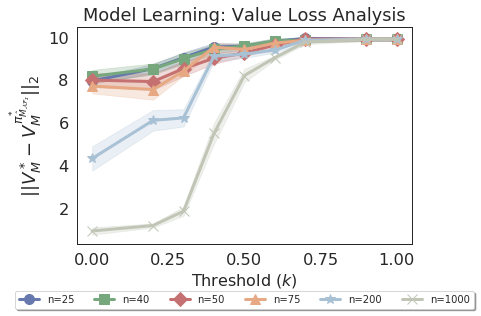

In [39]:
#@title Plotting Planning Value Loss Evaluation

fig, ax1 = plt.subplots()
x_axis = thresholds
for i in range(value_loss_to_plot.shape[0]):
  plt.plot(x_axis, value_loss_to_plot[i, :], color = colors[i],  label = 'n={}'.format(int(n_trajectories[i]/max_trajectory_length)),
           linewidth = 3.00, marker=markers[i], markersize=10)
  plt.fill_between(x_axis, value_loss_to_plot[i, :]-value_loss_to_plot_CI[i,:],
                   value_loss_to_plot[i, :]+value_loss_to_plot_CI[i,:],
                   facecolor=colors[i], edgecolor=colors[i], alpha=0.25)

ax1.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19),
          fancybox=True, shadow=True, ncol=7,
          facecolor='w', fontsize=10)
ax1.set_xlabel("Threshold ($k$)", fontsize=16)
ax1.set_ylabel("$||V^*_M - V^{\pi^{*}_{\hat{M}_{{{\mathcal{A} \mathcal{F}}_{\cal I}}}}}_M ||_2$", fontsize=18) 
plt.title("Model Learning: Value Loss Analysis")
matplotlib.rc('axes', edgecolor='black')
plt.show()

In [40]:
#@title Helper function to plot affordance arrows.

def plot_affordances_camera_ready(
    nstates, nactions, affordances, mdp, mdp_wall_locs, ax=None,
    headwidth=2.7, linewidths=1, scale=1.9, headlength=2,
    wall_color=(0, 0, 0, 1), grid_kwargs=None, figsize=(14, 8)):
  """
    Plots the environment  with walls.
    Args:
      nstates: Number of state in the mdp
      nactions: Number of actions in the mdp
      affordances: Affordances of shape |S| * |A|
      mdp: The mdp to plot
      mdp_wall_locs:Locations of the walls for plotting them in a different color
      ax: The axes to plot this on
      headwidth: quiver arguments for arrows
      linewidths: quiver arguments for arrows
      scale: quiver arguments for arrows
      headlength:  quiver arguments for arrows
      wall_color: RGB color of the walls
      grid_kwargs: grid argrument specification.
      figsize: Dimensions of the figure.

    Returns:
      Visualization of the environment
    """
  grid_kwargs = grid_kwargs or {}
  if ax is None:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
  plot_environment(
      mdp, ax,
      wall_locs=mdp_wall_locs,
      plot_grid=True,
      grid_kwargs=grid_kwargs,
      wall_color=wall_color)
  action_symbols = []
  for s in range(nstates):
    for a in range(nactions):
      one_hot_state = convert_int_rep_to_onehot(s, nstates)
      y_pos, x_pos =  mdp.unflatten_state(one_hot_state)
      if (y_pos, x_pos) not in mdp_wall_locs:
        if affordances[s, a] == 1.0:
          left_arrow = (-0.8, 0)
          right_arrow = (0.8, 0)
          up_arrow = (0, -0.8)
          down_arrow = (0, 0.8)
          if a == actions.LEFT:  # Left
            ax.quiver(
                x_pos,y_pos,*left_arrow, color=DEFAULT_ARROW_COLOR, alpha=1.0,
                angles='xy', scale_units='xy', scale=scale,
                headwidth=headwidth, linewidths=linewidths,
                headlength=headlength) #L
          if a == actions.RIGHT:  #Right
            ax.quiver(
                x_pos,y_pos,*right_arrow, color=DEFAULT_ARROW_COLOR, alpha=1.0,
                angles='xy', scale_units='xy', scale=scale,
                headwidth=headwidth, linewidths=linewidths,
                headlength=headlength) #R
          if a == actions.UP:  #Up
            ax.quiver(
                x_pos,y_pos,*up_arrow, color=DEFAULT_ARROW_COLOR, alpha=1.0,
                angles='xy', scale_units='xy', scale=scale,
                headwidth=headwidth, linewidths=linewidths,
                headlength=headlength) #U
          if a == actions.DOWN:  #Down
            ax.quiver(
                x_pos,y_pos,*down_arrow,color=DEFAULT_ARROW_COLOR, alpha=1.0,
                angles='xy', scale_units='xy', scale=scale,
                headwidth=headwidth, linewidths=linewidths,
                headlength=headlength) #D

  return ax


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


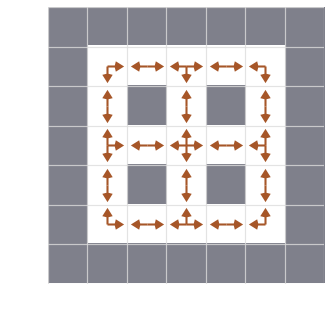

In [43]:
#@title Plot affordances computed from transition matrix.
intent_name = 'collection' #@param ["collection", "up", "left"]
world_name = 'pachinko' #@param ["pachinko", "one_room", "four_room"]
grid_size =  7#@param {type:'integer'}
headwidth =  5#@param {type:'number'}

if world_name == 'one_room':
  mdp, mdp_wall_locs = build_one_room_gridsize(grid_size=grid_size)
elif world_name == 'pachinko':
  mdp, mdp_wall_locs = build_pachinko_gridsize(grid_size=grid_size)
elif world_name == 'four_room':
  mdp, mdp_wall_locs = build_four_rooms_example()
else:
  raise ValueError('Unknown environment!')

AF = _compute_affordances(
    mdp,
    mdp.state_space,
    mdp.action_space,
    intent_name=intent_name,
    threshold=0.0,
    mdp_wall_locs=mdp_wall_locs)

if intent_name == 'up':
  AF[mdp.terminal_states[0], :] = 0
  AF[mdp.terminal_states[0], actions.LEFT] = 1

plot_affordances_camera_ready(
    mdp.state_space, 
    mdp.action_space, 
    affordances=AF, mdp=mdp,
    mdp_wall_locs=mdp_wall_locs,
    linewidths=0,
    headwidth=headwidth,
    headlength=4,
    wall_color=(220, 220, 220, 0.5),
    figsize=(5,5),
    grid_kwargs={'color':(220 / 255, 220 / 255, 220 / 255, 0.8)}
    )
plt.axis('off')
plt.tight_layout()

# Sec 7.1 Learn Affordances

In [44]:
#@title Helper function to collect data from environment.
class Intent(enum.IntEnum):
  completed = 1.0
  incomplete = 0.0

def get_trajectories(
    mdp, num_rollouts=500, max_trajectory_length=50, policy=None,
    intent_name='collection', random_starts=False, seed=None):
  """Takes trajectory samples from an environment.

  Args:
    mdp: The MDP to evaluate the intent on.
    num_rollouts: The total number of trajectories to sample.
    max_trajectory_length: The maximum length of the trajectory.
    policy: The policy to sample using. If none is given a random policy
      is used. The policy must take a single argument, the one hot
      representation of the state. If using a tensorflow function make sure to
      handle batching within the policy itself.
    intent_name: The name of the intent to evalaute.
    random_starts: randomly sampled start state per rollout
    seed: set a specific seed

  Returns:
    The trajectories collected from the environment:
      This is a 4-tuple containing the batch of state, action, state' and intent
      target.
    Human Readable transitions:
      A set containing the unique transitions in the trajectory batch and if the
      intent was completed.
  """
  if seed is not None:
    np.random.seed(seed)
    random.seed(seed)
    mdp.set_seed(seed)

  trajectory = []
  if random_starts:
    s_t = get_randomized_state(mdp)
  else:
    s_t = mdp.reset()
  trajectory_length = 0
  human_readable = set()
  if policy is None:
    def policy(_):
      return np.random.randint(mdp.action_space)

  for _ in range(num_rollouts):
    action = policy(s_t)
    s_tp1, reward, done, _ = mdp.step(action)
    state_int = get_current_state_integer(s_t)
    intent = _get_intent_completed(
        mdp, s_t, action, s_tp1, intent_name=intent_name)

    # Human readable vesion:
    human_readable.add((
        mdp.unflatten_state(s_t),
        Actions(action),
        mdp.unflatten_state(s_tp1),
        Intent(intent)))

    # Prepare things for tensorflow:
    s_tf = tf.constant(s_t.astype(np.float32))
    s_tp1_tf = tf.constant(s_tp1.astype(np.float32))
    a_tf = tf.one_hot(action, mdp.action_space)
    # The mask will only consider the action that was actually taken.
    mask_tf = tf.cast(a_tf, tf.float32)
    # Computing targets
    if intent > 0.0:
      # if a completed the intent I_a(s')
      targets = tf.one_hot(action, mdp.action_space)
    else:
      # vector of zeros if action a completed no intent.
      targets = tf.zeros_like(a_tf)

    trajectory.append((
        s_tf, a_tf, s_tp1_tf, targets)
    )
    trajectory_length += 1
    if done or trajectory_length > max_trajectory_length:
      if random_starts:
        s_t = get_randomized_state(mdp)
      else:
        s_t = mdp.reset()
    else:
      s_t = s_tp1

  trajectory = list(map(tf.stack, zip(*trajectory)))
  
  return trajectory, human_readable

In [45]:
#@title Function: Populate Learned Affordances
def get_learned_affordances(mdp, affordnet, classification_threshold=0.55):
  '''Gets the learned affordances from the environment.
  Args:
    mdp: The mdp to get the affordances from.
    affordnet: The affordance network.
    classification_threshold: accuracy of the classifier

  Returns:
    affordances in the form of a |S| * |A|
  '''
  n_states, n_actions = mdp.state_space, mdp.action_space
  affordances = np.zeros((n_states, n_actions))
  for s in range(n_states):
    action_prob_predictions = affordnet(tf.eye(n_states))[s]
    actions_affordable = tf.where(
        tf.greater_equal(
            action_prob_predictions, tf.constant(classification_threshold)))[:,-1]
    for ind, a in enumerate(actions_affordable.numpy()):
      affordances[s,a] = 1.0
  return affordances

In [46]:
#@title Function: Affordance training code.
def train_afford_net(
    mdp, network, optimizer,
    intent_name='collection',
    num_train_steps=10,
    fresh_data=True,
    num_rollouts=1,
    max_trajectory_length=100,
    optimize_performance=False,
    debug=False,
    print_losses=False,
    random_starts=False,
    passing_data=False,
    trajectories=None,
    unique_transitions=None):
  """Trains an affordance network.

  Args:
    mdp: The mdp to collect training data from.
    network: The affordance network.
    optimizer: The optimizer to use for training.
    intent_name: The name of the intent to train affordances for.
    num_train_steps: The total number of training steps.
    fresh_data: Use fresh data at every before completing a training step.
    num_rollouts: The number of rollout trajectories per training step.
    max_trajectory_length: The maximum length of each trajectory
    optimizer_performance: Use tf.function to speed up training. (Right now
      there are no apparent speed benefits of this function...?)
    debug: Debug mode prints out the human readable transitions.
    print_losses: Prints out the losses at every training step.
    random_starts: randomly sampled start state per rollout
    passing_data: set True if previously collected data is being passed
    trajectories: tf trajectories from previously collected data
    unique_transitions: tf unique_transitions from previously collected data
  """  

  def _train_step(trajectory):
    with tf.GradientTape() as tape:
      s_t, a_t, s_tp1, intent_target = trajectory
      preds = network(s_t)
      mask = tf.cast(a_t, tf.float32)

      intent_target = tf.reshape(intent_target, (-1, 1))
      preds = tf.reshape(preds, (-1, 1))
      mask = tf.reshape(mask, (-1,))

      loss = tf.keras.losses.binary_crossentropy(intent_target, preds)
      masked_loss = (loss * mask)

      total_loss = tf.reduce_sum(masked_loss) / tf.reduce_sum(1-mask)
    grads = tape.gradient(total_loss, network.trainable_variables)
    optimizer.apply_gradients(zip(grads, network.trainable_variables))

    return total_loss

  if optimize_performance and not debug:
    print('Training step has been optimized.')
    _train_step = tf.function(_train_step)

  initial_data_collected = False
  for i in range(num_train_steps):
    if not initial_data_collected or fresh_data:
      initial_data_collected = True
      running_time = time.time()
      if not passing_data:
        trajectories, unique_transitions = get_trajectories(
            mdp, num_rollouts=num_rollouts,
            max_trajectory_length=max_trajectory_length,
            intent_name=intent_name,
            random_starts=random_starts)
      else:
        trajectories = trajectories
        unique_transitions = unique_transitions
      collection_running_time = time.time() - running_time
      if debug: print('unique_transitions:', unique_transitions)
    running_time = time.time()
    loss = _train_step(trajectories)
    if debug or print_losses: 
      print(
          'loss:', loss.numpy().item(),
          'collection_loop_time', collection_running_time,
          'train_loop_time', time.time() - running_time)


Training step has been optimized.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


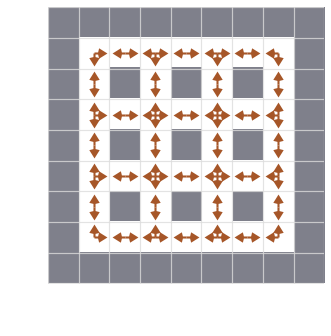

In [47]:
intent_name = 'collection' #@param {type:'string'}
world_name = 'pachinko' #@param {type:'string'}
grid_size =  9#@param {type:'integer'}
headwidth =  5#@param {type:'number'}
classification_threshold =  0.95#@param {type:'number'}
num_transitions = 2000#@param {type:'number'}
max_trajectory_length = 10#@param {type:'number'}

if world_name == 'one_room':
  mdp, mdp_wall_locs = build_one_room_gridsize(grid_size=grid_size)
elif world_name == 'pachinko':
  mdp, mdp_wall_locs = build_pachinko_gridsize(grid_size=grid_size)
elif world_name == 'four_room':
  mdp, mdp_wall_locs = build_four_rooms_example()


network = tf.keras.layers.Dense(
    mdp.action_space,
    activation=tf.keras.activations.sigmoid)

sgd = tf.keras.optimizers.Adam(learning_rate=0.1)

train_afford_net(
    mdp, 
    network,
    sgd,
    intent_name=intent_name,
    num_train_steps=5000,
    num_rollouts=num_transitions,
    fresh_data=False,
    max_trajectory_length=max_trajectory_length,
    debug=False,
    print_losses=False,
    optimize_performance=True,
    random_starts=True)

AF_learned = get_learned_affordances(
    mdp,
    affordnet=network, 
    classification_threshold=0.95)

plot_affordances_camera_ready(
    mdp.state_space, 
    mdp.action_space, 
    affordances=AF_learned, mdp=mdp,
    mdp_wall_locs=mdp_wall_locs,
    linewidths=0,
    headwidth=headwidth,
    headlength=4,
    wall_color=(220,220,220,0.5),
    figsize=(5,5),
    grid_kwargs={'color':(220/255,220/255,220/255,0.8)}
    )
plt.axis('off')
plt.tight_layout()